# Install Required Packages

In [2]:
!pip install opencv-python-headless
!pip install pyathena


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


# Import Required Libraries

In [3]:
import boto3 # aws sdk for python
import cv2 # computer vision
import sagemaker # machine learning platform
import matplotlib.pyplot as plt # plotting functions
import os # operating system interfaces
import pandas as pd # python data analysis
import random # pseudo-random numbers
import time # time access and conversions
from PIL import Image # python imaging library module
from pyathena import connect # athena client
from sagemaker import get_execution_role # get execution role for notebook
from sagemaker.feature_store.feature_group import FeatureGroup # featuregroup definition
from sagemaker.session import Session # class to initialize sagemaker session
from time import gmtime, strftime, sleep # time-related functions

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# Establish FeatureStore Session

In [4]:
# establish boto3 session
region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

# sagemaker client to make service calls
sagemaker_client = boto_session.client(
    service_name="sagemaker", region_name=region
)

# client to make featurestore record calls
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

# create featurestore session
feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# S3 Bucket Setup for OfflineStore

In [5]:
# we will use the default bucket
default_s3_bucket_name = feature_store_session.default_bucket()

# define custom prefix for the featurestore directory
prefix = 'safety-featurestore'

# print featurestore directory location
print('FeatureStore directory location:', f"s3://{default_s3_bucket_name}/{prefix}\n")

# print current IAM role for notebook instance
role = get_execution_role()
print('Execution Role:', role)

FeatureStore directory location: s3://sagemaker-us-east-1-414754026690/safety-featurestore

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Execution Role: arn:aws:iam::414754026690:role/LabRole


# Import Data

## Set Raw Data Source Location

In [6]:
# path contents should contain an 'images' and a 'labels' folder
# images are .jpg files and labels are .txt files
path_raw_data = './data'

# print raw data source location
print('Raw Data Source Location:', path_raw_data)

Raw Data Source Location: ./data


## Plot Random Samples with Labels (i.e., Annotations)

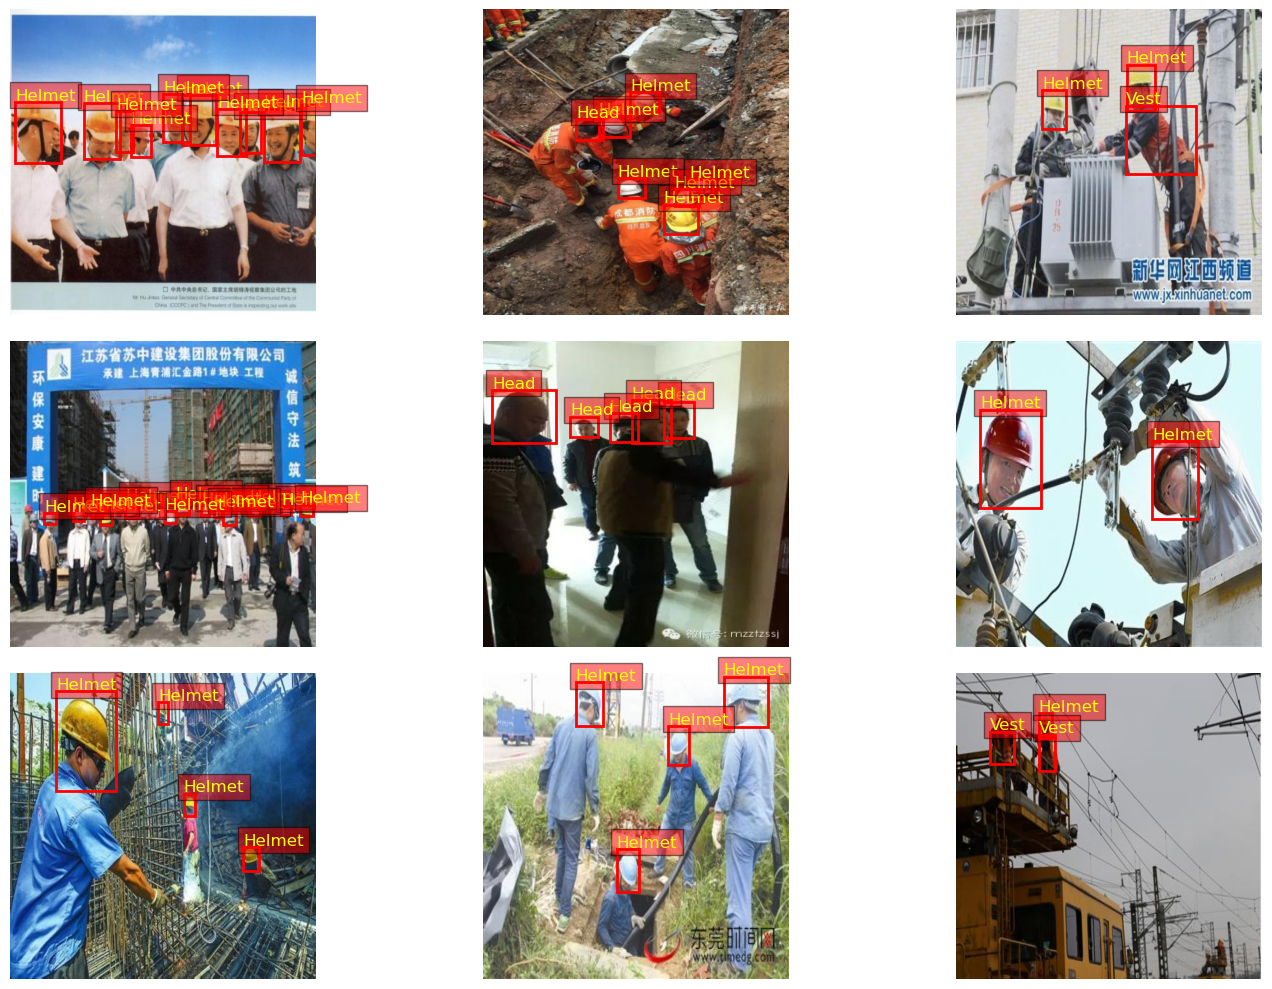

In [7]:
# dictionary to map class id to a name
class_id_to_name = {
    0: 'Helmet',
    1: 'Vest',
    2: 'Head',
    3: 'Person'
}

# define function to plot nine sample images with labels (i.e., bounding boxes)
def plot_images_with_labels(path_images, path_labels, num_images=9):
    
    # define subplot dimensions as 3 rows and 3 columns
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    # iterate through each sample
    for ax, path_image, path_label in zip(axes, path_images, path_labels):
        
        # read and convert the image
        img = cv2.imread(path_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert from BGR to RGB

        # read the labels file
        with open(path_label, 'r') as file:
            labels = file.readlines()

        # plot the image
        ax.imshow(img)

        # plot each bounding box and class id
        for label in labels:
            class_id, x_center, y_center, width, height = map(float, label.split())
            
            # convert relative coordinates to respective pixel values in image
            x_center = x_center * img.shape[1]
            y_center = y_center * img.shape[0]
            width = width * img.shape[1]
            height = height * img.shape[0]
            
            # determine locations used to find corners of bounding box
            xmin = int(x_center - width / 2)
            ymin = int(y_center - height / 2)
            xmax = int(x_center + width / 2)
            ymax = int(y_center + height / 2)

            # draw the bounding box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # display the class ID or name
            class_name = class_id_to_name.get(class_id, f"Class{int(class_id)}")
            ax.text(xmin, ymin - 5, class_name, color='yellow', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        # hide the axes
        ax.axis('off')

    # display the plot
    plt.tight_layout()
    plt.show()
    
# set path for images and labels directories
path_images = os.path.join(path_raw_data, 'images')
path_labels = os.path.join(path_raw_data, 'labels')
    
# get list of all images and annotations (i.e., labels)
list_images = os.listdir(path_raw_data + '/images')
list_labels = os.listdir(path_raw_data + '/labels')

# select nine random images and their corresponding labels
random_image_names = random.sample(list_images, 9)
random_image_paths = [os.path.join(path_images, img_name) for img_name in random_image_names]
random_label_paths = [os.path.join(path_labels, img_name.replace('.jpg', '.txt')) for img_name in random_image_names]

# plot the images with labels
plot_images_with_labels(random_image_paths, random_label_paths)

# Exploratory Data Analysis

In [8]:
# insert additional EDA steps here...

# Feature Engineering

## ImageFeatureGroup

In [9]:
# create list of image data
image_data = [['sample_id', 'img_format', 'img_mode', 'img_height', 'img_width']]

# iterate through each sample image
for sample in list_images:
    
    # read and convert the image
    img = Image.open(os.path.join(path_images, sample))
    
    # append sample image data to list
    image_data.append([sample.split('.')[0], img.format, img.mode, img.height, img.width])
                       
# create images dataframe
df_images = pd.DataFrame(image_data[1:], columns=image_data[0])
                       
# display dataframe head
df_images.head()

,sample_id,img_format,img_mode,img_height,img_width
0,000010,JPEG,RGB,640,640
1,000001,JPEG,RGB,640,640
2,000018,JPEG,RGB,640,640
3,000009,JPEG,RGB,640,640
4,000014,JPEG,RGB,640,640


## LabelFeatureGroup

In [10]:
# create list of label data
label_data = [['sample_id', 'count_helmet', 'count_vest', 'count_head', 'count_person']]

# iterate through each sample label
for sample in list_labels:
    
    # define counters for each class id
    count_helmet = 0
    count_vest = 0
    count_head = 0
    count_person = 0
    
    # read the labels file
    with open((os.path.join(path_labels, sample)), 'r') as file:
        labels = file.readlines()
        
    # iterate through each label and count occurrences of each class
    for label in labels:
        class_id = int(label.split(' ')[0])
        if class_id == 0:
            count_helmet += 1
        elif class_id == 1:
            count_vest += 1
        elif class_id == 2:
            count_head += 1
        elif class_id == 3:
            count_person += 1
        else:
            raise ValueError(f"Unexpected class_id: {class_id}. Please investigate.")
            
    # append sample label data to list
    label_data.append([sample.split('.')[0], count_helmet, count_vest, count_head, count_person])
                       
# create labels dataframe
df_labels = pd.DataFrame(label_data[1:], columns=label_data[0])
                       
# display dataframe head
df_labels.head()

,sample_id,count_helmet,count_vest,count_head,count_person
0,000011,13,0,0,0
1,000002,2,1,0,0
2,000020,2,0,0,0
3,000019,0,0,5,0
4,000015,2,0,0,0


# Ingest Data into FeatureStore

## Define FeatureGroups

In [11]:
# define feature group names
image_feature_group_name = 'image-feature-group-' + strftime("%d-%H-%M-%S", gmtime())
label_feature_group_name = 'label-feature-group-' + strftime("%d-%H-%M-%S", gmtime())

# instantiate image featuregroup object
image_feature_group = FeatureGroup(
    name=image_feature_group_name, sagemaker_session=feature_store_session
)

# instantiate label featuregroup object
label_feature_group = FeatureGroup(
    name=label_feature_group_name, sagemaker_session=feature_store_session
)

# get current time
current_time_sec = int(round(time.time()))

# define function to cast objets to strings for compatibility
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == 'object' or data_frame.dtypes[label] == 'category':
            data_frame[label] = data_frame[label].astype('str').astype('string')

# cast object dtype to string
cast_object_to_string(df_images)
cast_object_to_string(df_labels)

# record identifier and event time feature names
record_identifier_feature_name = 'sample_id'
event_time_feature_name = 'EventTime'

# append EventTime feature to images dataframe
df_images[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(df_images), dtype='float64'
)

# append EventTime feature to labels dataframe
df_labels[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(df_labels), dtype='float64'
)

## Load FeatureGroup Definitions

### Load Definitions for Image FeatureGroup

In [12]:
# load feature definitions to the image feature group
image_feature_group.load_feature_definitions(data_frame=df_images)

[FeatureDefinition(feature_name='sample_id', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='img_format', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='img_mode', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='img_height', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='img_width', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='EventTime', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None)]

### Load Definitions for Label FeatureGroup

In [13]:
# load feature definitions to the label feature group
label_feature_group.load_feature_definitions(data_frame=df_labels)

[FeatureDefinition(feature_name='sample_id', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='count_helmet', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='count_vest', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='count_head', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='count_person', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='EventTime', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None)]

## Create FeatureGroups in SageMaker FeatureStore

### Function to Monitor Creation Status

In [14]:
# define function to monitor featuregroup creation status
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

### Create Image FeatureGroup

In [15]:
# perform feature group creation for image featuregroup
image_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

# wait and monitor for image featuregroup creation to complete
wait_for_feature_group_creation_complete(feature_group=image_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup image-feature-group-31-02-35-20 successfully created.


### Create Label FeatureGroup

In [16]:
# perform feature group creation for label featuregroup
label_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

# wait and monitor for label featuregroup creation to complete
wait_for_feature_group_creation_complete(feature_group=label_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup label-feature-group-31-02-35-20 successfully created.


### Confirm FeatureGroup Creations

Confirm the FeatureGroup has been created by using the DescribeFeatureGroup and ListFeatureGroups APIs

#### Describe Image FeatureGroup

In [17]:
# describe image featuregroup
image_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:414754026690:feature-group/image-feature-group-31-02-35-20',
 'FeatureGroupName': 'image-feature-group-31-02-35-20',
 'RecordIdentifierFeatureName': 'sample_id',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'sample_id', 'FeatureType': 'String'},
  {'FeatureName': 'img_format', 'FeatureType': 'String'},
  {'FeatureName': 'img_mode', 'FeatureType': 'String'},
  {'FeatureName': 'img_height', 'FeatureType': 'Integral'},
  {'FeatureName': 'img_width', 'FeatureType': 'Integral'},
  {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}],
 'CreationTime': datetime.datetime(2024, 1, 31, 2, 35, 42, 154000, tzinfo=tzlocal()),
 'OnlineStoreConfig': {'EnableOnlineStore': True},
 'OfflineStoreConfig': {'S3StorageConfig': {'S3Uri': 's3://sagemaker-us-east-1-414754026690/safety-featurestore',
   'ResolvedOutputS3Uri': 's3://sagemaker-us-east-1-414754026690/safety-featurestore/414754026690/sagemaker/us-east-1/offline-

#### Describe Label FeatureGroup

In [18]:
# describe label featuregroup
label_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:414754026690:feature-group/label-feature-group-31-02-35-20',
 'FeatureGroupName': 'label-feature-group-31-02-35-20',
 'RecordIdentifierFeatureName': 'sample_id',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'sample_id', 'FeatureType': 'String'},
  {'FeatureName': 'count_helmet', 'FeatureType': 'Integral'},
  {'FeatureName': 'count_vest', 'FeatureType': 'Integral'},
  {'FeatureName': 'count_head', 'FeatureType': 'Integral'},
  {'FeatureName': 'count_person', 'FeatureType': 'Integral'},
  {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}],
 'CreationTime': datetime.datetime(2024, 1, 31, 2, 36, 9, 275000, tzinfo=tzlocal()),
 'OnlineStoreConfig': {'EnableOnlineStore': True},
 'OfflineStoreConfig': {'S3StorageConfig': {'S3Uri': 's3://sagemaker-us-east-1-414754026690/safety-featurestore',
   'ResolvedOutputS3Uri': 's3://sagemaker-us-east-1-414754026690/safety-featurestore/414754026690/sagemaker/us-east-

#### List Image FeatureGroup

In [19]:
# use boto client to list image featuregroup
sagemaker_client.list_feature_groups(NameContains=image_feature_group_name)

{'FeatureGroupSummaries': [{'FeatureGroupName': 'image-feature-group-31-02-35-20',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:414754026690:feature-group/image-feature-group-31-02-35-20',
   'CreationTime': datetime.datetime(2024, 1, 31, 2, 35, 42, 154000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'}],
 'ResponseMetadata': {'RequestId': '92699608-effe-43dc-9a47-17d632a17eb7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '92699608-effe-43dc-9a47-17d632a17eb7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '252',
   'date': 'Wed, 31 Jan 2024 02:36:55 GMT'},
  'RetryAttempts': 0}}

#### List Label FeatureGroup

In [20]:
# use boto client to list label featuregroup
sagemaker_client.list_feature_groups(NameContains=label_feature_group_name)

{'FeatureGroupSummaries': [{'FeatureGroupName': 'label-feature-group-31-02-35-20',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:414754026690:feature-group/label-feature-group-31-02-35-20',
   'CreationTime': datetime.datetime(2024, 1, 31, 2, 36, 9, 275000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'}],
 'ResponseMetadata': {'RequestId': 'cce17432-d84b-4710-96d4-2d161d6aad5e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'cce17432-d84b-4710-96d4-2d161d6aad5e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '252',
   'date': 'Wed, 31 Jan 2024 02:37:05 GMT'},
  'RetryAttempts': 0}}

## Put Records into FeatureGroups

In [21]:
# ingest data into featuregroups
image_feature_group.ingest(data_frame=df_images, max_workers=3, wait=True)
label_feature_group.ingest(data_frame=df_labels, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='label-feature-group-31-02-35-20', sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7f41bbaf0b20>, sagemaker_session=<sagemaker.session.Session object at 0x7f4210e3b0a0>, max_workers=3, max_processes=1, profile_name=None, _async_result=<multiprocess.pool.MapResult object at 0x7f41b9693670>, _processing_pool=<pool ProcessPool(ncpus=1)>, _failed_indices=[])

## Retrieve Sample Records from Online Store

### Connect to Athena Database Catalog

In [22]:
# define database name
database_name = 'safetydb'

# define table name
table_name_csv = 'catalog_csv'

# define default bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()

# set s3 temporary staging directory
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# define connection parameters
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Define Catalog Query SQL Statement

In [23]:
# define sql query statement
statement = """SELECT * FROM {}.{}
    WHERE sample_id >= '000015'
    AND img_filename like '%.jpg'
    AND label_filename like '%.txt'
    LIMIT 1""".format(
    database_name, table_name_csv
)

# print sql statement for review before executing
print('SQL query SELECT statement:\n', statement)

SQL query SELECT statement:
 SELECT * FROM safetydb.catalog_csv
    WHERE sample_id >= '000015'
    AND img_filename like '%.jpg'
    AND label_filename like '%.txt'
    LIMIT 1


### Perform Catalog Query

In [24]:
# execute sql query and display results
df = pd.read_sql(statement, conn)
df.head(5)

/tmp/ipykernel_1077/2784951185.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,sample_id,img_filename,label_filename
0,000015,000015.jpg,000015.txt


### Query Matching Records from Each FeatureGroups

In [25]:
# print single sample_id value to use as record identifier for querying featuregroups
record_id = df.at[0, 'sample_id']
print('record_identifier_value:', record_id)

record_identifier_value: 000015


#### Query Single FeatureGroup (Image FeatureGroup)

In [26]:
# specify the record_id
record_identifier_value = str(record_id)

# query image featuregroup by using record_id as primary key
featurestore_runtime.get_record(
    FeatureGroupName=image_feature_group_name,
    RecordIdentifierValueAsString=record_identifier_value,
)

{'ResponseMetadata': {'RequestId': '4e558aa5-8c0b-4593-ac57-68c9646c1e66',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4e558aa5-8c0b-4593-ac57-68c9646c1e66',
   'content-type': 'application/json',
   'content-length': '493',
   'date': 'Wed, 31 Jan 2024 02:37:50 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'sample_id', 'ValueAsString': '000015'},
  {'FeatureName': 'img_format', 'ValueAsString': 'JPEG'},
  {'FeatureName': 'img_mode', 'ValueAsString': 'RGB'},
  {'FeatureName': 'img_height', 'ValueAsString': '640'},
  {'FeatureName': 'img_width', 'ValueAsString': '640'},
  {'FeatureName': 'EventTime', 'ValueAsString': '1706668520.0'}]}

#### Query Single FeatureGroup (Label FeatureGroup)

In [27]:
# query label featuregroup by using record_id as primary key
featurestore_runtime.get_record(
    FeatureGroupName=label_feature_group_name,
    RecordIdentifierValueAsString=record_identifier_value,
)

{'ResponseMetadata': {'RequestId': '5bdfe33a-cd2a-4b25-b00d-e2d6fd83fb58',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5bdfe33a-cd2a-4b25-b00d-e2d6fd83fb58',
   'content-type': 'application/json',
   'content-length': '491',
   'date': 'Wed, 31 Jan 2024 02:38:06 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'sample_id', 'ValueAsString': '000015'},
  {'FeatureName': 'count_helmet', 'ValueAsString': '2'},
  {'FeatureName': 'count_vest', 'ValueAsString': '0'},
  {'FeatureName': 'count_head', 'ValueAsString': '0'},
  {'FeatureName': 'count_person', 'ValueAsString': '0'},
  {'FeatureName': 'EventTime', 'ValueAsString': '1706668520.0'}]}

#### Query Both FeatureGroups Using Primary Key

In [28]:
# now query both feature groups simultaneously using primary key
featurestore_runtime.batch_get_record(
    Identifiers=[
        {
            'FeatureGroupName': image_feature_group_name,
            'RecordIdentifiersValueAsString': [str(record_id)],
        },
        {
            'FeatureGroupName': label_feature_group_name,
            'RecordIdentifiersValueAsString': [str(record_id)],
        },
    ]
)

{'ResponseMetadata': {'RequestId': '72e1f458-e258-4381-89c3-3b03c61d63e3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '72e1f458-e258-4381-89c3-3b03c61d63e3',
   'content-type': 'application/json',
   'content-length': '1227',
   'date': 'Wed, 31 Jan 2024 02:38:16 GMT'},
  'RetryAttempts': 0},
 'Records': [{'FeatureGroupName': 'image-feature-group-31-02-35-20',
   'RecordIdentifierValueAsString': '000015',
   'Record': [{'FeatureName': 'sample_id', 'ValueAsString': '000015'},
    {'FeatureName': 'img_format', 'ValueAsString': 'JPEG'},
    {'FeatureName': 'img_mode', 'ValueAsString': 'RGB'},
    {'FeatureName': 'img_height', 'ValueAsString': '640'},
    {'FeatureName': 'img_width', 'ValueAsString': '640'},
    {'FeatureName': 'EventTime', 'ValueAsString': '1706668520.0'}]},
  {'FeatureGroupName': 'label-feature-group-31-02-35-20',
   'RecordIdentifierValueAsString': '000015',
   'Record': [{'FeatureName': 'sample_id', 'ValueAsString': '000015'},
    {'FeatureName': 'c

# Confirm Data Availability in Offline Store

In [29]:
# obtain and print account id
account_id = boto3.client("sts").get_caller_identity()["Account"]
print('Account ID:', account_id)

# define s3 client
s3_client = boto3.client("s3", region_name=region)

# image featuregroup
image_feature_group_resolved_output_s3_uri = (
    image_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)

# label featuregroup
label_feature_group_resolved_output_s3_uri = (
    label_feature_group.describe()
    .get("OfflineStoreConfig")
    .get("S3StorageConfig")
    .get("ResolvedOutputS3Uri")
)

# image featuregroup
image_feature_group_s3_prefix = image_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)

# label featuregroup
label_feature_group_s3_prefix = label_feature_group_resolved_output_s3_uri.replace(
    f"s3://{default_s3_bucket_name}/", ""
)

# wait and monitor status for data availability
offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket=default_s3_bucket_name, Prefix=image_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...\n")
        sleep(60)

print("Data available.")

Account ID: 414754026690
Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Waiting for data in offline store...

Data available.
